In [1]:
#All file names and corresponding redshifts
files = [['1RXSJ0603',0.22631],['A115',0.19285],['A521',0.24676],['A523',0.10389],
         ['A746',0.21434],['A781',0.29748],['A1240',0.19457],
         ['A1300',0.30550],['A1612',0.18229],['A2034',0.11381],
         ['A2061',0.07805],['A2163',0.20115],['A2255',0.08012],
         ['A2345',0.17881],['A2744',0.30590],['A3365',0.09282],
         ['A3411',0.16255],['CIZAJ2242',0.18865],['MACSJ1149',0.54362],
         ['MACSJ1752',0.36470],['PLCKG287',0.38321],
         ['RXCJ1053',0.07217],['RXCJ1314',0.24703],['ZwCl0008',0.10383],
         ['ZwCl1447',0.37574],['ZwCl1856',0.30362],['ZwCl2341',0.26960]]
#REMOVED A2443 and PSZG108

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.io import fits

#Main function to create image and light profile, returns FWHM
def main(name):    
    image_data = get(name)
    plot(image_data,name)
    profile_data = medians(image_data)
    FWHM_value = profile(profile_data,name)
    return FWHM_value     

In [3]:
#Open fits file for plotting and analysis
def get(name):
    image_file = fits.open('%s.fits' % (name))
    if name == 'ZwCl0008' or name == 'MACSJ1752':
        image_data = image_file[1].data
    else:
        image_data = image_file[0].data
    return image_data

In [4]:
#Plot and save image
def plot(image_data,name):
    plt.style.use(astropy_mpl_style)
    fig = plt.figure()
    plt.imshow(image_data, origin = 'lower', cmap='gray_r')
    cbar = plt.colorbar()
    cbar.set_label('Brightness')
    plt.annotate('%s' % (name), xy = (0,0), textcoords = 'axes fraction', xytext = (0.025,0.925), size = 18)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    #plt.show()
    fig.savefig('./PDFs/%s.pdf' % (name))
    plt.close(fig)

In [5]:
#searches for maximum value of the array within a certain x and y range
#returns max value and coordinate as tuple
def max_search(array,xmin,xmax,ymin,ymax):
    x_pos = xmin
    y_pos = ymin
    x_max_pos = 0
    y_max_pos = 0
    max = 0
    for y_pos in range(ymin, ymax + 1):
        for  x_pos in range(xmin, xmax + 1):
            if max <= array[x_pos,y_pos]:
                max = array[x_pos,y_pos]
                x_max_pos = x_pos
                y_max_pos = y_pos
    #print "Max of %d at (%d,%d)\n" % (max, x_max_pos, y_max_pos)  
    return (max,x_max_pos,y_max_pos)
    

In [6]:
#checks array elements in a circle using midpoint circle algorithm
#finds median value along circle and returns it
def circle_check(array,x0,y0,r):
    copy = array
    values = np.array([])
    median = np.array([])
    f = 1 - r
    x = 0
    y = r
    dx = 1
    dy = -2 * r
    
    values = np.append(values,array[x0 + r, y0])
    values = np.append(values,array[x0 - r, y0])  
    values = np.append(values,array[x0, y0 + r])
    values = np.append(values,array[x0, y0 - r])
    
    while x < y:
        if f >= 0:
            y -= 1
            dy += 2
            f += dy
        
        x += 1
        dx += 2
        f += dx
        
        values = np.append(values,array[x0 + x, y0 + y])
        values = np.append(values,array[x0 - x, y0 + y])
        values = np.append(values,array[x0 + x, y0 - y])
        values = np.append(values,array[x0 - x, y0 - y])
        values = np.append(values,array[x0 + y, y0 + x])
        values = np.append(values,array[x0 - y, y0 + x])
        values = np.append(values,array[x0 + y, y0 - x])
        values = np.append(values,array[x0 - y, y0 - x])
        
        '''
        copy[x0 + x, y0 + y] = 30000
        copy[x0 - x, y0 + y] = 30000 
        copy[x0 + x, y0 - y] = 30000
        copy[x0 - x, y0 - y] = 30000
        copy[x0 + y, y0 + x] = 30000 
        copy[x0 - y, y0 + x] = 30000
        copy[x0 + y, y0 - x] = 30000
        copy[x0 - y, y0 - x] = 30000
        '''
        
    #print values
    #print np.median(values)
    median = np.append(median,np.median(values))

    return median

In [7]:
#Finds max brightness with max_search and uses circle_check to calculate medians for 
#radii up to 1/3 of the image size, returns list of medians and the maximum radius checked
def medians(image_data):
    size = image_data.shape
    #print "Image Size: %s\n" % (size,)
    max_inf = max_search(image_data,(size[0]/2)-(size[0]/20),(size[0]/2)+(size[0]/20),(size[1]/2)-(size[1]/20),
                     (size[1]/2)+(size[1]/20))
    image_medians = np.array([])
    if size[0] > size[1]:
        max_r = (size[1]/3)
    if size[0] <= size[1]:
        max_r = (size[0]/3)
    for i in range(0,max_r):
        image_medians = np.append(image_medians,circle_check(image_data,max_inf[1],max_inf[2],i)/max_inf[0])
    return (image_medians,max_r)

In [8]:
#Finds FWHM and returns pixel value for radius
def FWHM(arr):
    diff = 10
    i = 0
    while diff > 0.01:
        diff = abs(arr[i]-0.5)
        i += 1
        
    return (i-1)/100.0

In [9]:
#Plot light profile and FWHM 
def profile(profile_data,name):
    xp = np.arange(0,profile_data[1],1)
    x = np.arange(0,profile_data[1],0.01)
    yinterp = np.interp(x,xp,profile_data[0])

    fig = plt.figure()
    plt.semilogy(x,yinterp)
    plt.axvline(FWHM(yinterp), color = 'r')
    #plt.annotate('FWHM = %.2f' % (FWHM(yinterp)), xy = (5,0.01), textcoords = 'axes fraction', xytext = (0.8,0.96))
    plt.annotate('FWHM = %.2f' % (FWHM(yinterp)), xy = (5,0.01))
    plt.xlabel('Pixel Radius from Brightest Pixel')
    plt.ylabel('Brightness')
    fig.savefig('./PDFs/%s_profile.pdf' % (name))
    plt.close(fig)
    #plt.show()
    return FWHM(yinterp)

In [10]:
#Gets FWHM for each file and creates image and light profile for each BCG
FWHM_list = []
for file in files:
    FWHM_list.append(main(file[0]))
    print '%s is complete' % (file[0])
print 'Finished!'
#print FWHM_list

1RXSJ0603 is complete
A115 is complete
A521 is complete
A523 is complete
A746 is complete
A781 is complete
A1240 is complete
A1300 is complete
A1612 is complete
A2034 is complete
A2061 is complete
A2163 is complete
A2255 is complete
A2345 is complete
A2744 is complete
A3365 is complete
A3411 is complete
CIZAJ2242 is complete
MACSJ1149 is complete
MACSJ1752 is complete
PLCKG287 is complete
RXCJ1053 is complete
RXCJ1314 is complete
ZwCl0008 is complete
ZwCl1447 is complete
ZwCl1856 is complete
ZwCl2341 is complete
Finished!


In [11]:
import cosmo
i = 0
FWHM_dist = np.array([])

#Converts FWHM pixels to Kpc
for FWHM_pix in FWHM_list:
    FWHM_dist = np.append(FWHM_dist,(FWHM_pix*(1/5.0)*(1/60.0))*cosmo.ProjectedLength(files[i][1])*(1000))
    i += 1
print FWHM_dist


[ 2.08483719  2.19473993  2.31742639  2.89379031  3.36591286  3.29696455
  1.68671661  3.55669968  1.41746387  4.04827293  2.16005737  2.24215097
  2.90194631  3.02101699  2.36724203  1.8999895   2.58340667  1.55767238
  4.8988716   2.9541095   5.52981229  1.60389753  4.14991984  1.50721042
  2.80349302  2.42700318  2.01725902]


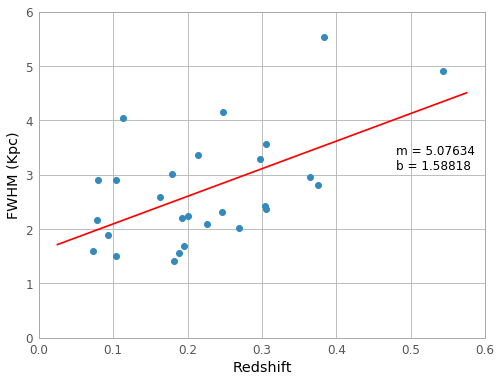

In [12]:
#Plot data for FWHM vs. Redshift and create linear fit
z = np.array([])
for file in files:
     z = np.append(z,file[1])    
        
linear_fit = np.polyfit(z,FWHM_dist,1)
linear_fit_fn = np.poly1d(linear_fit)
fit_x = np.arange(0.025,0.577,0.01)

fig = plt.figure()
plt.scatter(z,FWHM_dist)
plt.plot(fit_x,linear_fit_fn(fit_x),'r')
plt.xlabel('Redshift')
plt.ylabel('FWHM (Kpc)')
plt.xlim(0,0.6)
plt.ylim(0,6)
plt.annotate('m = %.5f\nb = %.5f' %  (linear_fit[0],linear_fit[1]), xy = (0.48,3.1))
plt.show()
fig.savefig('FWHM.pdf')

In [13]:
#Plot and save image
def plot_show(image_data,name):
    plt.style.use(astropy_mpl_style)
    fig = plt.figure()
    plt.imshow(image_data, cmap='gray_r')
    cbar = plt.colorbar()
    cbar.set_label('Brightness')
    plt.annotate('%s' % (name), xy = (10,15),size = 18) 
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    plt.show()
    #fig.savefig('./PDFs_new/%s.pdf' % (name))
    plt.close(fig)

In [14]:
def residuals(residue,profile_data,x0,y0,r):
    
    f = 1 - r
    x = 0
    y = r
    dx = 1
    dy = -2 * r
    
    residue[x0 + r, y0] = 30000
    residue[x0 - r, y0] = 30000
    residue[x0, y0 + r] = 30000
    residue[x0, y0 - r] = 30000
    
    '''
    residuals[x0 + r, y0] = image_data[x0 + r, y0]-profile_data[0][r]
    residuals[x0 - r, y0] = image_data[x0 - r, y0]-profile_data[0][r]  
    residuals[x0, y0 + r] = image_data[x0, y0 + r]-profile_data[0][r]
    residuals[x0, y0 - r] = image_data[x0, y0 - r]-profile_data[0][r]
    '''
    
    while x < y:
        if f >= 0:
            y -= 1
            dy += 2
            f += dy
        
        x += 1
        dx += 2
        f += dx
        
        residue[x0 + x, y0 + y] = 30000
        residue[x0 - x, y0 + y] = 30000
        residue[x0 + x, y0 - y] = 30000
        residue[x0 - x, y0 - y] = 30000
        residue[x0 + y, y0 + x] = 30000
        residue[x0 - y, y0 + x] = 30000
        residue[x0 + y, y0 - x] = 30000
        residue[x0 - y, y0 - x] = 30000
        
        '''
        residuals[x0 + x, y0 + y] = image_data[x0 + x, y0 + y]-profile_data[0][r]
        residuals[x0 - x, y0 + y] = image_data[x0 - x, y0 + y]-profile_data[0][r]
        residuals[x0 + x, y0 - y] = image_data[x0 + x, y0 - y]-profile_data[0][r]
        residuals[x0 - x, y0 - y] = image_data[x0 - x, y0 - y]-profile_data[0][r]
        residuals[x0 + y, y0 + x] = image_data[x0 + y, y0 + x]-profile_data[0][r]
        residuals[x0 - y, y0 + x] = image_data[x0 - y, y0 + x]-profile_data[0][r]
        residuals[x0 + y, y0 - x] = image_data[x0 + y, y0 - x]-profile_data[0][r]
        residuals[x0 - y, y0 - x] = image_data[x0 - y, y0 - x]-profile_data[0][r]
        '''
    #print residuals
    #plot_show(residuals,'A521')
    return residuals

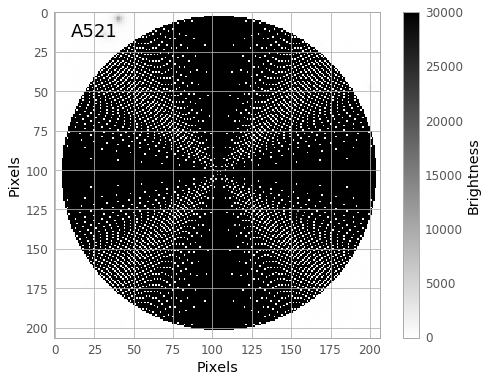

In [15]:
image_data = get('A521')
profile_data = medians(image_data)
max_data = max_search
residue = image_data

'''
residuals(residue,profile_data,102,104,3)
'''
for i in range(0,100):
    residuals(residue,profile_data,102,104,i)
    i += 1
plot_show(residue,'A521')
